In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters Config

In [3]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

# Data Generation

In [5]:
def gen_data(size, op, max_len, digits, reverse=False):
    if op not in '+-':
        raise Exception("Only supprt '+' and '-' operation")
    questions = []
    expected = []
    seen = set()
    while len(questions) < size:
        f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, digits + 1))))
        a, b = f(), f()
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        if op == '-' and a < b:
            a, b = b, a
        q = '{}{}{}'.format(a, op, b)
        query = q + ' ' * (max_len - len(q))
        ans = str(eval(q))
        ans += ' ' * (digits + 1 - len(ans))
        if reverse:
            query = query[::-1]
        questions.append(query)
        expected.append(ans)
    return questions, expected

# Processing

In [6]:
def vectorization(questions, expected, ctable, max_len, digits):
    x = np.zeros((len(questions), max_len, len(chars)), dtype=np.bool)
    y = np.zeros((len(expected), digits + 1, len(chars)), dtype=np.bool)
    for i, sentence in enumerate(questions):
        x[i] = ctable.encode(sentence, max_len)
    for i, sentence in enumerate(expected):
        y[i] = ctable.encode(sentence, digits + 1)
    return x, y

In [7]:
def train_test_split(x, y):
    indices = np.arange(len(y))
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]

    # train_test_split
    split_at = len(y) - len(y)//10
    x_train = x[:split_at]
    y_train = y[:split_at]
    x_val = x[split_at:]
    y_val = y[split_at:]

    print('Training Data:')
    print(x_train.shape)
    print(y_train.shape)

    print('Testing Data:')
    print(x_val.shape)
    print(y_val.shape)

    return x_train, x_val, y_train, y_val

# Build Model

In [8]:
def build_model(hidden_size, max_len, digits, chars, rnn=layers.LSTM):
    print('Build model...')

    model = Sequential()
    model.add(rnn(hidden_size, input_shape=(max_len, len(chars))))
    model.add(layers.RepeatVector(digits + 1))
    model.add(rnn(hidden_size, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    return model

# Training

In [9]:
def train(model, x_train, x_val, y_train, y_val, epochs, batch_size=128, verbose=False):
    return model.fit(x_train,
                     y_train,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_data=(x_val, y_val),
                     verbose=verbose)

def plot_result(result):
    accs = ['acc', 'val_acc']
    for acc in accs:
        plt.plot(result.history[acc])
    plt.legend(accs)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    
def accuracy(model, x_val, y_val):
    return model.evaluate(x_val, y_val)[1]

def result_sampling(model, x_val, y_val, ctable, num_sample=10, reverse=False):
    for i in range(num_sample):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if reverse else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

## 1. Adder

### Config

In [10]:
chars = '0123456789+ '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [11]:
xs, ys = gen_data(data_size, '+', max_len, digits)
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Testing Data:
(2000, 7, 12)
(2000, 4, 12)


### Build model and train

In [12]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


### Analysis

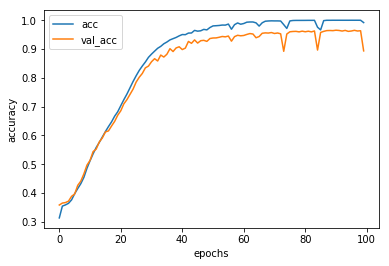

Q 5+468   T 473  ☒ 474 
Q 987+4   T 991  ☒ 992 
Q 820+823 T 1643 ☒ 1633
Q 47+573  T 620  ☑ 620 
Q 1+206   T 207  ☒ 106 
Q 723+53  T 776  ☑ 776 
Q 9+686   T 695  ☑ 695 
Q 180+757 T 937  ☑ 937 
Q 160+11  T 171  ☒ 161 
Q 6+122   T 128  ☒ 127 
2000/2000 [==============================] - 0s 75us/step
Test accuracy: 0.893625


In [13]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))

## 2. Subtractor

### Config

In [14]:
chars = '0123456789- '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [15]:
xs, ys = gen_data(data_size, '-', max_len, digits)
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 12)
(18000, 4, 12)
Testing Data:
(2000, 7, 12)
(2000, 4, 12)


### Build model and train

In [16]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


### Analysis

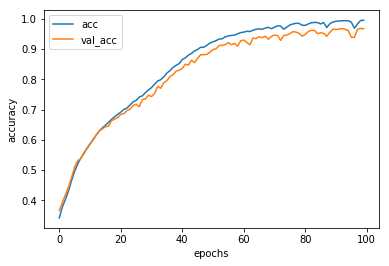

Q 908-53  T 855  ☑ 855 
Q 811-30  T 781  ☒ 780 
Q 655-59  T 596  ☑ 596 
Q 390-2   T 388  ☑ 388 
Q 911-197 T 714  ☑ 714 
Q 123-4   T 119  ☑ 119 
Q 807-301 T 506  ☒ 507 
Q 388-77  T 311  ☑ 311 
Q 250-37  T 213  ☑ 213 
Q 816-590 T 226  ☒ 216 
2000/2000 [==============================] - 0s 70us/step
Test accuracy: 0.967


In [17]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))

## 3. Combine adder and subtractor

### Config

In [18]:
chars = '0123456789+- '
ctable = CharacterTable(chars)
digits = 3
max_len = digits + 1 + digits
epochs = 100
hidden_size = 128
data_size = 20000

### Generate data

In [19]:
xs_add, ys_add = gen_data(data_size//2, '+', max_len, digits)
xs_sub, ys_sub = gen_data(data_size//2, '-', max_len, digits)
xs = xs_add + xs_sub
ys = ys_add + ys_sub
xs, ys = vectorization(xs, ys, ctable, max_len, digits)
x_train, x_val, y_train, y_val = train_test_split(xs, ys)

Training Data:
(18000, 7, 13)
(18000, 4, 13)
Testing Data:
(2000, 7, 13)
(2000, 4, 13)


### Build model and train

In [20]:
model = build_model(hidden_size=hidden_size, max_len=max_len, digits=digits, chars=chars)
result = train(model, x_train, x_val, y_train, y_val, epochs)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               72704     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 13)             1677      
Total params: 205,965
Trainable params: 205,965
Non-trainable params: 0
_________________________________________________________________


### Analysis

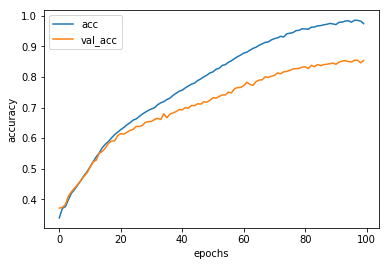

Q 502-7   T 495  ☑ 495 
Q 387-39  T 348  ☒ 349 
Q 76+943  T 1019 ☒ 1020
Q 995-3   T 992  ☑ 992 
Q 412-8   T 404  ☑ 404 
Q 608-53  T 555  ☑ 555 
Q 6+995   T 1001 ☑ 1001
Q 9+392   T 401  ☑ 401 
Q 995+105 T 1100 ☒ 1102
Q 910-37  T 873  ☒ 863 
2000/2000 [==============================] - 0s 68us/step
Test accuracy: 0.853625


In [21]:
plot_result(result)
result_sampling(model, x_val, y_val, ctable)
print('Test accuracy: {}'.format(accuracy(model, x_val, y_val)))